In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from time import strptime,time,mktime
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.decomposition import PCA
from seaborn import heatmap,pairplot
from sklearn.feature_selection import SelectKBest,mutual_info_regression

In [373]:
colors=['red','green','blue','yellow','violet','#00ffff','#ff00bf','#937f3c','#937f91','#630ff0']

In [374]:
df1=pd.read_csv("../resources/Excel_sheets/Car_sales.csv")
df1.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [375]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   155 non-null    float64
 6   Engine_size          156 non-null    float64
 7   Horsepower           156 non-null    float64
 8   Wheelbase            156 non-null    float64
 9   Width                156 non-null    float64
 10  Length               156 non-null    float64
 11  Curb_weight          155 non-null    float64
 12  Fuel_capacity        156 non-null    float64
 13  Fuel_efficiency      154 non-null    float64
 14  Latest_Launch        157 non-null    object 
 15  Power_perf_factor    155 non-null    flo

lowercasing column names for easiness

In [376]:
df1.columns=[x.lower() for x in df1.columns]
df1.head(2)

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,price_in_thousands,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,latest_launch,power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778


## DATA CLEANING

In [377]:
df1.isnull().sum()

manufacturer            0
model                   0
sales_in_thousands      0
__year_resale_value    36
vehicle_type            0
price_in_thousands      2
engine_size             1
horsepower              1
wheelbase               1
width                   1
length                  1
curb_weight             2
fuel_capacity           1
fuel_efficiency         3
latest_launch           0
power_perf_factor       2
dtype: int64

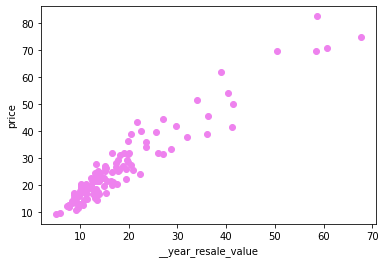

In [378]:
plt.scatter(df1.__year_resale_value,df1.price_in_thousands,color=colors[4])
plt.xlabel('__year_resale_value')
plt.ylabel('price')
plt.show()

from this scatter plot it is evident that price and year_resale_value are linearly related
hence we can use linear_regression model to predict the missing values

In [379]:
len(df1[df1[['__year_resale_value','price_in_thousands']].isna().all(axis=1)])

0

both are not null hence we can use linear_regression model with any problem

In [380]:
d_df=df1.dropna(subset=['__year_resale_value','price_in_thousands'])
y=d_df.__year_resale_value.values
X=d_df.price_in_thousands.values.reshape(-1,1)

In [381]:
model1=LinearRegression()
model1.fit(X,y)
model1.score(X,y)

0.9098114540463296

In [382]:
df2=df1.copy()
d=df1[df1.__year_resale_value.isna()]
n=d.index
df2.loc[n,['__year_resale_value']]=model1.predict(d[['price_in_thousands']])
df2.__year_resale_value.isna().sum()

0

In [383]:
m=model1.coef_
b=model1.intercept_

In [384]:
d=df2[df2.price_in_thousands.isna()]
n=d.index
df2.loc[n,['price_in_thousands']]=(d.__year_resale_value.values-b)/m[0]
df2.price_in_thousands.isna().sum()

0

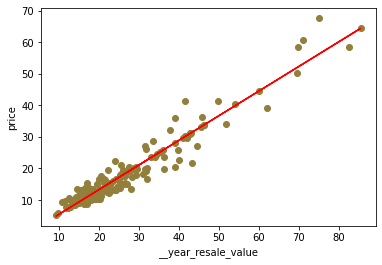

In [385]:
plt.scatter(df2.price_in_thousands,df2.__year_resale_value,color=colors[7])
plt.plot(df2.price_in_thousands,model1.predict(df2[['price_in_thousands']]),color=colors[0])
plt.xlabel('__year_resale_value')
plt.ylabel('price')
plt.show()

filling null in other columns with  mean

In [386]:
df3=df2.copy()
for column in df2.columns:
    if df2[column].isnull().sum():
        df3[column]=df2[column].fillna(df2[column].mean())
        
df4.isnull().sum()

manufacturer           0
model                  0
sales_in_thousands     0
__year_resale_value    0
vehicle_type           0
price_in_thousands     0
engine_size            0
horsepower             0
wheelbase              0
width                  0
length                 0
curb_weight            0
fuel_capacity          0
fuel_efficiency        0
latest_launch          0
power_perf_factor      0
dtype: int64

### Feature Engineering

In [388]:
df3.latest_launch.unique()

array(['2/2/2012', '6/3/2011', '1/4/2012', '3/10/2011', '10/8/2011',
       '8/9/2011', '2/27/2012', '6/28/2011', '1/29/2012', '4/4/2011',
       '11/2/2011', '9/3/2011', '3/23/2012', '7/23/2011', '2/23/2012',
       '4/29/2011', '11/27/2011', '9/28/2011', '4/17/2012', '8/17/2011',
       '3/19/2012', '5/24/2011', '12/22/2011', '10/23/2011', '5/12/2012',
       '9/11/2011', '4/13/2012', '6/18/2011', '1/16/2012', '11/17/2011',
       '6/6/2012', '10/6/2011', '5/8/2012', '7/13/2011', '2/10/2012',
       '12/12/2011', '7/1/2012', '10/31/2011', '6/2/2012', '8/7/2011',
       '3/6/2012', '1/6/2012', '7/26/2012', '11/25/2011', '6/27/2012',
       '9/1/2011', '3/31/2012', '1/31/2012', '8/20/2012', '12/20/2011',
       '7/22/2012', '9/26/2011', '4/25/2012', '2/25/2012', '9/14/2012',
       '1/14/2012', '8/16/2012', '10/21/2011', '5/20/2012', '3/21/2012',
       '10/9/2012', '2/8/2012', '9/10/2012', '11/15/2011', '6/14/2012',
       '4/15/2012', '11/3/2012', '3/4/2012', '10/5/2012', '12/10/2011

All the launch dates are within 2012 ,

i will create a new column which coverts date into no of days from launch date to 1/1/13

In [389]:
t=mktime(strptime('1/1/2013',"%m/%d/%Y"))

In [391]:
df4=df3.copy()
day=24*3600
df4['days_after_launch(1/1/13)']=df3['latest_launch'].apply(lambda x: int((t-mktime(strptime(x,"%m/%d/%Y")))/day))
df4.drop('latest_launch',axis=1,inplace=True)
df4.head(2)

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,price_in_thousands,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13)
0,Acura,Integra,16.919,16.360,Passenger,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150,334
1,Acura,TL,39.384,19.875,Passenger,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778,578


moving target variable to left for easiness

In [392]:
cols=df4.columns.tolist()
cols.append(cols.pop(cols.index('price_in_thousands')))
df4=df4[cols]
df4.head(2)

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13),price_in_thousands
0,Acura,Integra,16.919,16.360,Passenger,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150,334,21.5
1,Acura,TL,39.384,19.875,Passenger,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778,578,28.4


### Outlier detection

In [393]:
df4.describe()

,sales_in_thousands,__year_resale_value,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13),price_in_thousands
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.00000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,52.998076,19.066135,3.060897,185.948718,107.487179,71.15000,187.343590,3.378026,17.951923,23.844156,77.043591,394.229299,27.387714
std,68.029422,11.515161,1.041299,56.518297,7.616772,3.44079,13.388635,0.626447,3.875440,4.241326,24.980973,243.625524,14.259704
min,0.110000,5.160000,1.000000,55.000000,92.600000,62.60000,149.400000,1.895000,10.300000,15.000000,23.276272,3.000000,9.235000
25%,14.114000,12.025000,2.300000,150.000000,103.000000,68.40000,177.600000,2.975000,15.800000,21.000000,60.727447,213.000000,18.145000
50%,29.450000,15.408956,3.000000,180.000000,107.000000,70.60000,187.800000,3.368000,17.200000,24.000000,72.290355,388.000000,23.400000
75%,67.956000,20.940000,3.500000,215.000000,112.200000,73.40000,196.100000,3.778000,19.500000,26.000000,89.401935,544.000000,31.930000
max,540.561000,67.550000,8.000000,450.000000,138.700000,79.90000,224.500000,5.572000,32.000000,45.000000,188.144323,1784.000000,85.500000


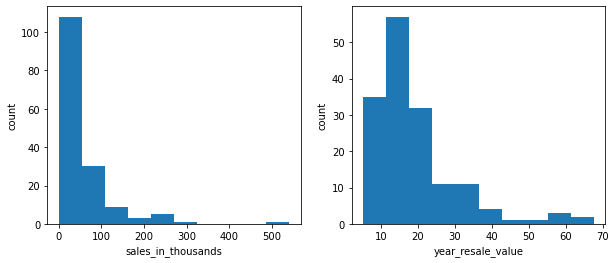

In [422]:
figu,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df4.sales_in_thousands)
ax[1].hist(df4.__year_resale_value)
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[0].set_xlabel('sales_in_thousands')
ax[1].set_xlabel('year_resale_value')
plt.show()

i will use 3 std as criteria for outlier deleting all which are more than 3 std

In [394]:
def remove_outlier(df):
    num_df_cols=df.select_dtypes(include=[np.number]).columns
    d=pd.DataFrame(columns=df.columns.to_list().append('outlier'))
    for col in num_df_cols:
        mean=df[col].mean()
        std=df[col].std()
        u_limit=mean+3*std
        l_limit=mean-3*std
        out=df[(df[col]<l_limit) | (df[col]>u_limit)].copy()
        out['outlier']=col
        d=pd.concat([out,d])
        df=df[(df[col]>l_limit) & (df[col]<u_limit)]
    return (df,d)
    
df5,d=remove_outlier(df4)
d

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13),price_in_thousands,outlier
94,Mercedes-B,S-Class,16.774,50.375000,Passenger,4.3,275.0,121.5,73.1,203.1,4.133,23.2,21.0,125.273876,568,69.700,price_in_thousands
90,Mercury,Mountaineer,27.609,20.430000,Car,4.0,210.0,111.6,70.2,190.1,3.876,21.0,18.0,85.949744,1784,27.560,days_after_launch(1/1/13)
91,Mercury,Villager,20.380,14.795000,Car,3.3,170.0,112.2,74.9,194.7,3.944,20.0,21.0,69.671461,1169,22.510,days_after_launch(1/1/13)
110,Oldsmobile,Alero,80.255,11.960415,Passenger,2.4,150.0,107.0,70.1,186.7,2.958,15.0,27.0,60.727447,1169,18.270,days_after_launch(1/1/13)
6,Audi,A8,1.380,39.000000,Passenger,4.2,310.0,113.0,74.0,198.2,3.902,23.7,21.0,134.656858,309,62.000,power_perf_factor
26,Chevrolet,Metro,21.855,5.160000,Passenger,1.0,55.0,93.1,62.6,149.4,1.895,10.3,45.0,23.276272,263,9.235,fuel_efficiency
41,Dodge,Ram Wagon,16.767,15.510000,Car,3.9,175.0,109.6,78.8,192.6,4.245,32.0,15.0,71.135292,361,21.315,fuel_capacity
42,Dodge,Ram Van,31.038,13.425000,Car,3.9,175.0,127.2,78.8,208.5,4.298,32.0,16.0,70.078322,159,18.575,fuel_capacity
18,Cadillac,Escalade,14.785,33.746620,Car,5.7,255.0,117.5,77.0,201.2,5.572,30.0,15.0,109.509117,259,46.225,curb_weight
74,Lexus,LX470,9.126,44.563737,Car,4.7,230.0,112.2,76.4,192.5,5.401,25.4,15.0,105.760458,63,60.105,curb_weight


most of the outliers are seems to be valid but still it is better to remove 
them for building better model

In [395]:
df4.shape[0]-df5.shape[0]

21

we removed 21 outliers

##  Data Analysis & Visualisation

1. Manufacturer

In [25]:
df4['manufacturer'].nunique()

30

In [26]:
Manf_name=df4['manufacturer'].unique()
Manf_name

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Lexus', 'Lincoln', 'Mitsubishi', 'Mercury',
       'Mercedes-B', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Saab', 'Saturn', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

#### Top 10 companies with highest no of cars[models]

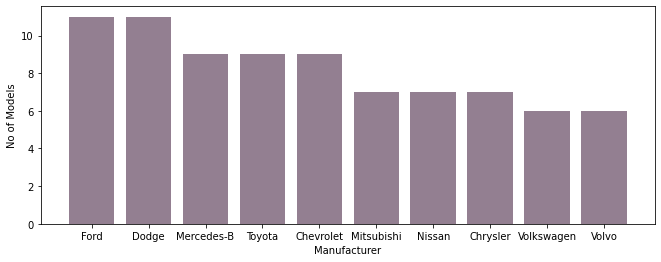

In [423]:
high_mod=df4['manufacturer'].value_counts()[:10]
plt.figure(figsize=(11,4))
plt.bar(high_mod.index.values,high_mod.values,color='#937f91')
plt.ylabel('No of Models')
plt.xlabel('Manufacturer')
plt.show()

Dodge and Toyota has highest no of model

2. Model

In [164]:
d=df4['model'].value_counts()
mod=d[d>1].index.values
mod

array(['Neon'], dtype=object)

In [166]:
df4[df4.model==mod[0]].manufacturer.values

array(['Dodge', 'Plymouth'], dtype=object)

Doged and Polymouth has cars of same model name as Neon

3. Sales

In [31]:
sales=df4.groupby('manufacturer')['sales_in_thousands'].sum().sort_values(ascending =False)
sal_10=sales[:10]
l=sal_10.index[:9].to_list()
l.append('other')
sal_10.index=l
sal_10[9]=sum(sales.values[10:])

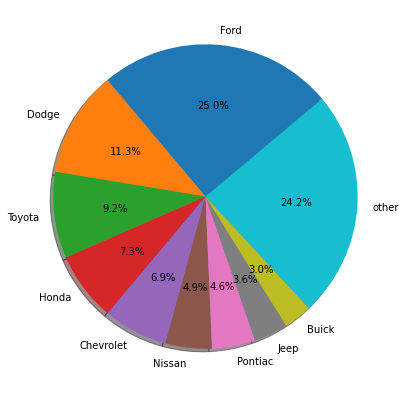

In [343]:
plt.figure(figsize=(7,7))
plt.pie(sal_10,startangle=40,autopct='%1.1f%%',shadow=True,labels=sal.index)
plt.show()

ford has highest sales 

In [429]:
df6=df4.copy()
df6['sell_price']=df6.sales_in_thousands*df6.price_in_thousands
sell_price=df6.groupby('manufacturer')['sell_price'].sum().sort_values(ascending =False)[:10]

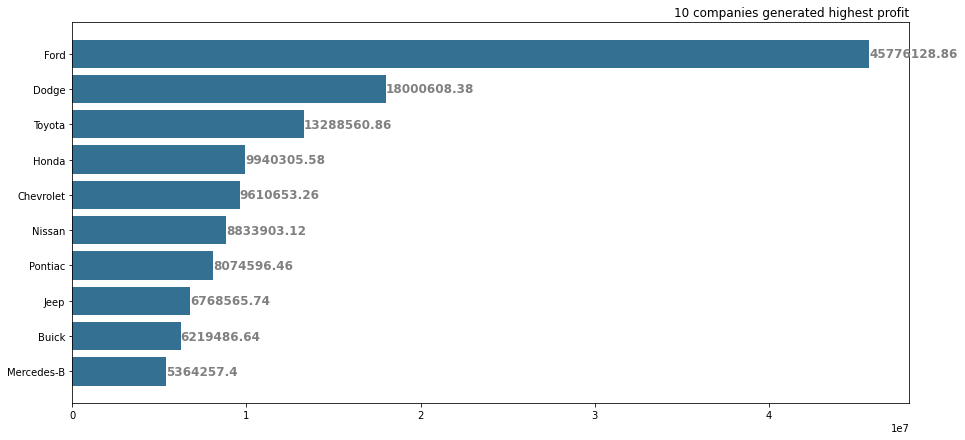

In [435]:
figu,ax=plt.subplots(figsize=(15,7))
ax.barh(sell_price.index.values,sell_price.values*1000,color='#337091')
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.1,i.get_y()+0.5,str(round(i.get_width(),2)),fontsize=12,fontweight="bold",color="grey")
ax.set_title("10 companies generated highest profit",loc="right")
plt.show()

Ford is generating highest revenue by providing more no of models

In [442]:
df6.head()

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13),price_in_thousands,sell_price
0,Acura,Integra,16.919,16.360,Passenger,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150,334,21.500000,363.758500
1,Acura,TL,39.384,19.875,Passenger,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778,578,28.400000,1118.505600
2,Acura,CL,14.114,18.225,Passenger,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,77.043591,363,26.308411,371.316914
3,Acura,RL,8.588,29.725,Passenger,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779,663,42.000000,360.696000
4,Audi,A4,20.397,22.255,Passenger,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639,451,23.990000,489.324030


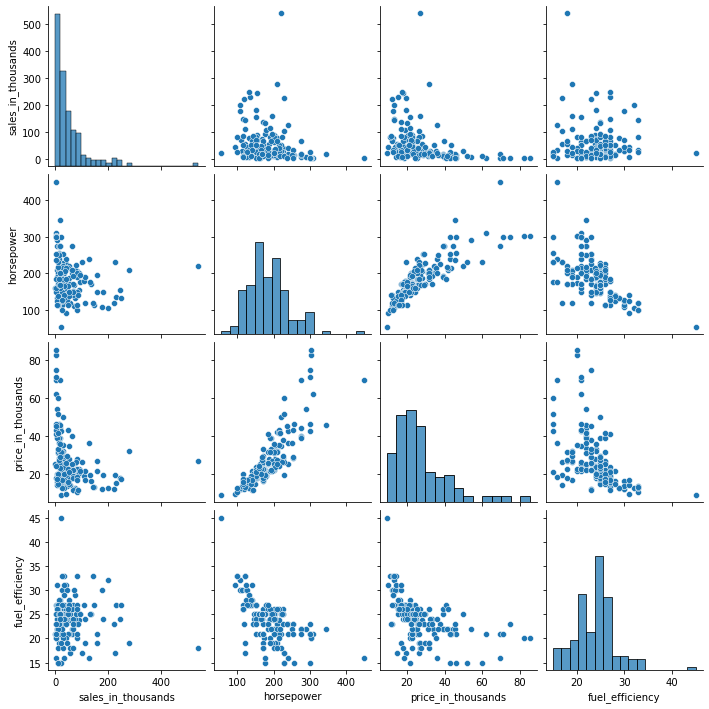

In [449]:
pairplot(df4[['sales_in_thousands','horsepower','price_in_thousands','fuel_efficiency']])

* we can observe all the histograms are right skewed and some ouliers present in all graph
(outliers are already deleted here i used old dataframe)
* cars with lower price sell more than higher one 
* cars with higher horsepower has lesser fuelefficiency



## DATA POCESSING AND BUILDING MODEL FOR TARGET AS PRICE

### DATA PREPROCESSING

In [46]:
df5[df5.model=='Neon']

,manufacturer,model,sales_in_thousands,__year_resale_value,vehicle_type,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,days_after_launch(1/1/13),price_in_thousands


model named neon has 2 manufacturers and we can observe that two model has same features
except sales and lauch date this probably be data error we shall delete these

In [89]:
df7=df5.copy()

In [36]:
df7.drop(df7[df7.model=='Neon'].index,inplace=True)

In [90]:
nam=df7[['model','price_in_thousands']].sort_values(by='price_in_thousands').model.values
encod=OrdinalEncoder(categories=[nam])
df7.model=encod.fit_transform(df5[['model']])

In [94]:
df7.vehicle_type.replace({'Car':0,'Passenger':1},inplace=True)

In [97]:
name=df7.groupby('manufacturer')['price_in_thousands'].mean().sort_values().index
encod2=OrdinalEncoder(categories=[name])
df7.manufacturer=encod2.fit_transform(df5[['manufacturer']])

<AxesSubplot:>

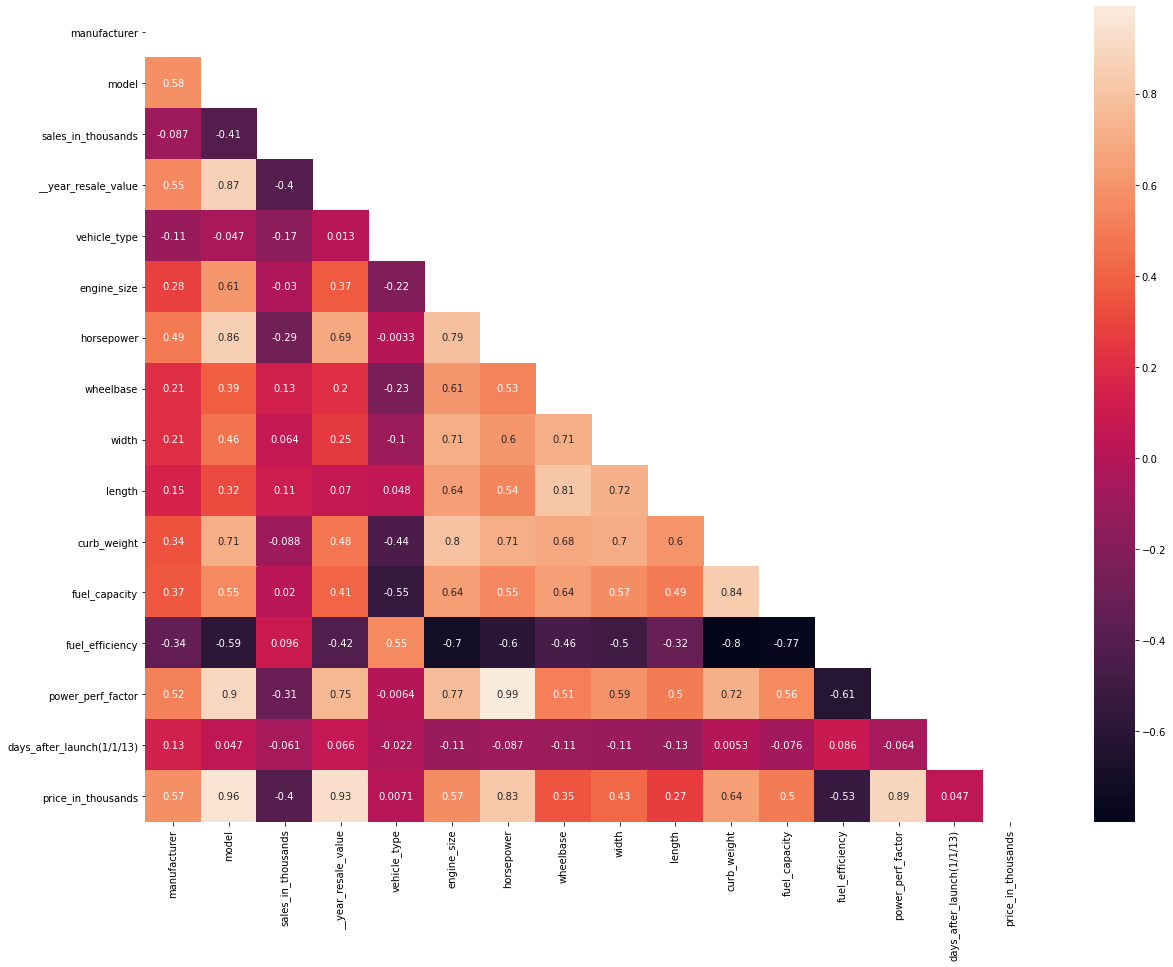

In [98]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(df7.corr(), dtype=bool))
heatmap(df7.corr(),annot=True,mask=mask)

there is strong multicollinearity between many of the features price of car 

vehicle_type and launch date has no relation with any of the values hence i will drop those columns

power_factor and horsepower has high collrellation hence we can drop horsepower column

year_resale_value , power_factor and model has highest influence on price of car

In [112]:
drop_list=['wheelbase','length','width','sales_in_thousands',\
           'fuel_capacity','vehicle_type','days_after_launch(1/1/13)','horsepower']
df8=df7.drop(drop_list,axis=1).copy()

I will reduce all the column having correlation value less than 0.5 to 1 column using PCA

In [113]:
pca=PCA(n_components=1)
df8['pca1']=pca.fit_transform(df7[['wheelbase','length','width','sales_in_thousands','fuel_capacity']])
df8.head(2)

,manufacturer,model,__year_resale_value,engine_size,curb_weight,fuel_efficiency,power_perf_factor,price_in_thousands,pca1
0,124.0,54.0,16.360,1.8,2.639,28.0,58.280150,21.5,-34.050747
1,124.0,96.0,19.875,3.2,3.517,25.0,91.370778,28.4,-10.924929


In [105]:
pca.explained_variance_ratio_

array([0.93163824])

In [116]:
X=df8.drop('price_in_thousands',axis=1)

Scaling of data

In [117]:
scale=StandardScaler()
X_scaled=scale.fit_transform(X)

In [120]:
y=df8.price_in_thousands

### MODEL Building

In [159]:
models=[Lasso(),Ridge(),LinearRegression(),RandomForestRegressor() \
         ,DecisionTreeRegressor(),SVR(C=10),KNeighborsRegressor()]

score=[]
for model in models:
    score.append(cross_val_score(model,X_scaled,y,n_jobs=-1).mean())
pd.DataFrame(score,index=models).sort_values(by=0,ascending=False)

,0
RandomForestRegressor(),0.990962
DecisionTreeRegressor(),0.990478
Ridge(),0.938681
LinearRegression(),0.938285
Lasso(),0.932936
SVR(C=10),0.909150
KNeighborsRegressor(),0.891864


Randomforestregressor ouperformed all other model with accuracy of 99%

## DATA PROCESSING AND BUILDING MODEL FOR TARGET AS SALES

###  Data Preprocessing

In [301]:
df9=df5.copy()

In [302]:
df9.drop(df9[df9.model=='Neon'].index,inplace=True)

I will encode categorical  columns with no according to their sales

In [303]:
nam=df9[['model','sales_in_thousands']].sort_values(by='sales_in_thousands').model.values
encod=OrdinalEncoder(categories=[nam])
df9.model=encod.fit_transform(df9[['model']])

In [304]:
df9.vehicle_type.replace({'Car':0,'Passenger':1},inplace=True)

In [305]:
name=df9.groupby('manufacturer')['sales_in_thousands'].mean().sort_values().index
encod2=OrdinalEncoder(categories=[name])
df9.manufacturer=encod2.fit_transform(df9[['manufacturer']])

<AxesSubplot:>

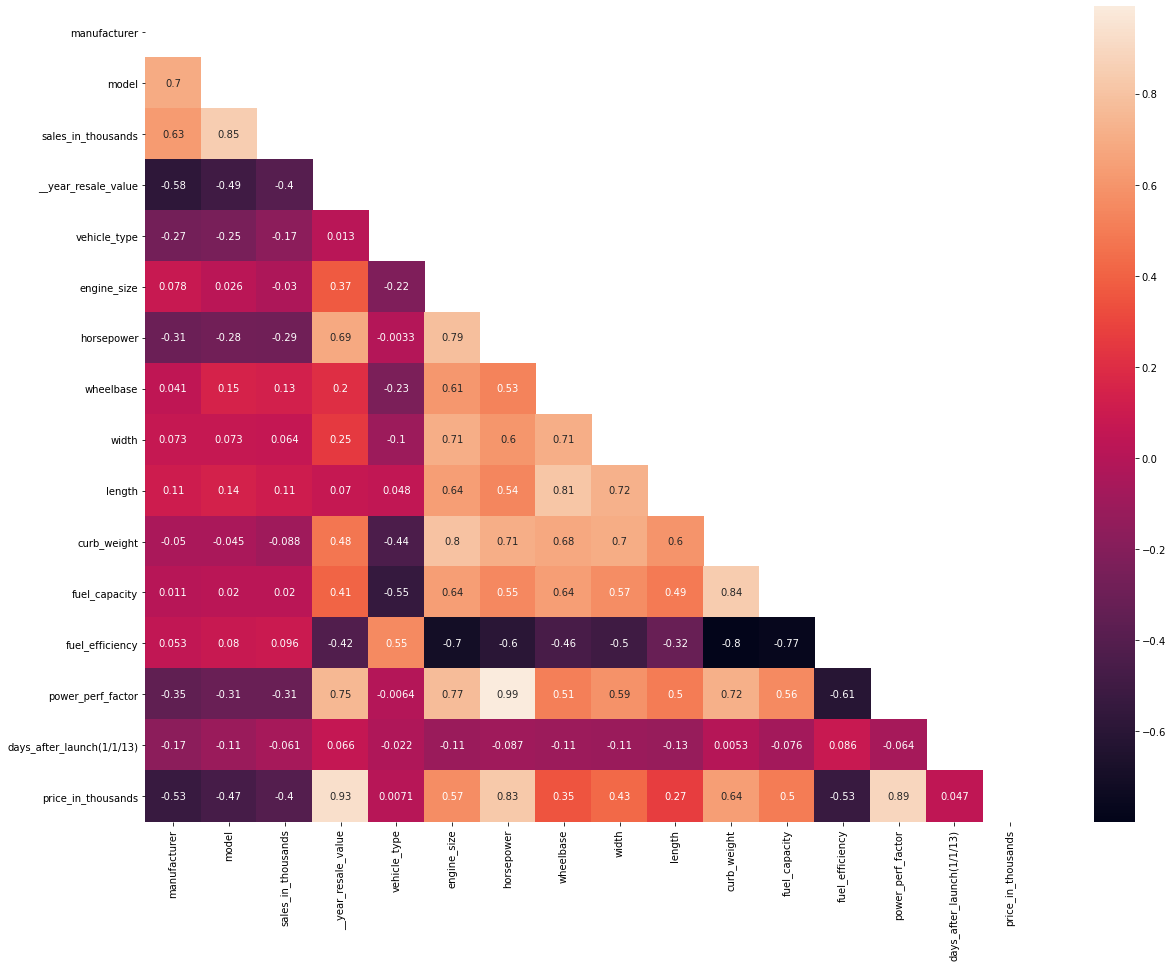

In [306]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(df9.corr(), dtype=bool))
heatmap(df9.corr(),annot=True,mask=mask)

most of the features donot have correlation with no of sales 

i will  use sklearn SelectKBest to find 5 most sutable column

In [307]:
X = df9.drop('sales_in_thousands',axis=1)
y = df9.sales_in_thousands
bestfeatures = SelectKBest(score_func=mutual_info_regression,k=10)
fit = bestfeatures.fit(X,y)
dbest= pd.DataFrame(fit.scores_,columns=['score'])
dbest['col_nam']= pd.DataFrame(X.columns)
dbest.sort_values(by='score',ascending=False,inplace=True)
dbest

,score,col_nam
1,2.649925,model
0,0.480052,manufacturer
2,0.188093,__year_resale_value
14,0.149260,price_in_thousands
10,0.054343,fuel_capacity
12,0.047352,power_perf_factor
7,0.021163,width
3,0.009412,vehicle_type
6,0.002943,wheelbase
4,0.000000,engine_size


In [308]:
most_related=dbest.col_nam.values[:5]
df10=df9[most_related].copy()

In [309]:
pca=PCA(1)
df10['pca1']=pca.fit_transform(df9[dbest.col_nam.values[5:]])
df10.head(2)

,model,manufacturer,__year_resale_value,price_in_thousands,fuel_capacity,pca1
0,38.0,10.0,16.360,21.5,13.2,46.297867
1,76.0,10.0,19.875,28.4,17.2,-195.434418


In [310]:
pca.explained_variance_ratio_

array([0.939214])

<AxesSubplot:>

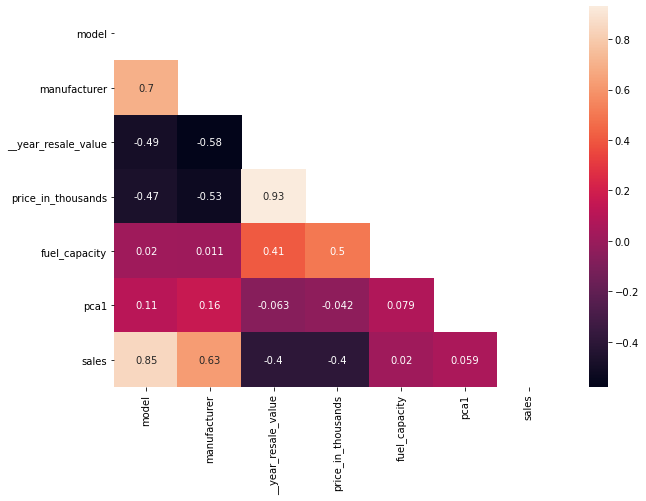

In [311]:
df10['sales']=df9.sales_in_thousands
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(df10.corr(), dtype=bool))
heatmap(df10.corr(),annot=True,mask=mask)

In [312]:
X_sales=df10.drop('sales',axis=1)
y_sales=df10.sales

In [313]:
scale_sales=StandardScaler()
X_scaled_sales=scale.fit_transform(X)

### Model Building

In [426]:
models_sales=[RandomForestRegressor(),DecisionTreeRegressor()]

score_sales=[]
for model in models_sales:
    score_sales.append(cross_val_score(model,X_scaled_sales,y_sales,n_jobs=-1).mean())
pd.DataFrame(score_sales,index=models_sales).sort_values(by=0,ascending=False)

,0
DecisionTreeRegressor(),0.984911
RandomForestRegressor(),0.977084
